# Predicting Recidivism of Crimes

The dataset contains 7214 criminal defendants from Broward County, Florida, and numerous information from which I selected the most important and relevant to predict recidivism of offence. 

I selected the following features

- - Sex 
- Race: African-American, Caucasian, Hispanic, Native American, Asian, other...
- Age
- Prior crimes count 
- Current charge degree: felony or misdemeanour (F or M)
- Juvenile records: whether the defendant has juvenile records (binary: 0 or 1)
- Two years recidivism (TARGET): whether the criminal defendant has re-offended after two years from the previous offence. (binary: 0 or 1)

 The goal is to predict whether criminal defendants have committed again a crime after two years from the previous offence, therefore the task that has to be performed is a binary classification.

Source of the dataset: https://www.kaggle.com/datasets/danofer/compass

## Data Loading

### Importing Modules

In [1]:

!pip install imbalanced-learn==0.10.1



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


I have had some issues with the different versions of imbalanced learn and scikit learn, therefore I decided to specifically install versions of them that don't give problems and are compatible.

In [2]:
!pip install scikit-learn==1.2.2

import sklearn
import imblearn 


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
import itertools
import pandas as pd
import numpy as np      #per fare calcoli
import matplotlib as mpl
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,StandardScaler, MinMaxScaler,LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV, 
    RepeatedStratifiedKFold, cross_validate, learning_curve, GridSearchCV
)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import Perceptron, LinearRegression
from imblearn.over_sampling import SMOTENC, RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

In [4]:
crimes = pd.read_csv('crimes.csv')
crimes 

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## Preliminary Selection

First of all, I decided to create a new column that merges three features into one: I felt it was more informative and clearer to haver a feature that tells whether a criminal defendant has had juvenile records before, without knowing the details of the juvenile record.

Any kind of juvenile record becomes 1 in the new feature "has_juvenile_record".

In [5]:
crimes['has_juvenile_record'] = (
    (crimes['juv_fel_count'] > 0) |
    (crimes['juv_misd_count'] > 0) |
    (crimes['juv_other_count'] > 0)
).astype(int)


In [6]:
columns_to_keep = [
    'two_year_recid',     
    'priors_count',
    'age',
    'sex',
    'race',
    'c_charge_degree',
    'has_juvenile_record',
]

crimes = crimes[columns_to_keep].copy()
crimes         

,two_year_recid,priors_count,age,sex,race,c_charge_degree,has_juvenile_record
0,0,0,69,Male,Other,F,0
1,1,0,34,Male,African-American,F,0
2,1,4,24,Male,African-American,F,1
3,0,1,23,Male,African-American,F,1
4,0,2,43,Male,Other,F,0
...,...,...,...,...,...,...,...
7209,0,0,23,Male,African-American,F,0
7210,0,0,23,Male,African-American,F,0
7211,0,0,57,Male,Other,F,0
7212,0,3,33,Female,African-American,M,0


In [7]:
print(crimes['two_year_recid'].unique())

[0 1]


I used the value_counts() function to count the occurrences of each unique value in the 'two_year_recid' column, from which I understand that there is only a very slight imbalance in the classes.

In [8]:
print(crimes['two_year_recid'].value_counts())

two_year_recid
0    3963
1    3251
Name: count, dtype: int64


Using this graph, we can visually understand how the classes of the target feature are distributed, on the left the 0s and on the right the 1s.

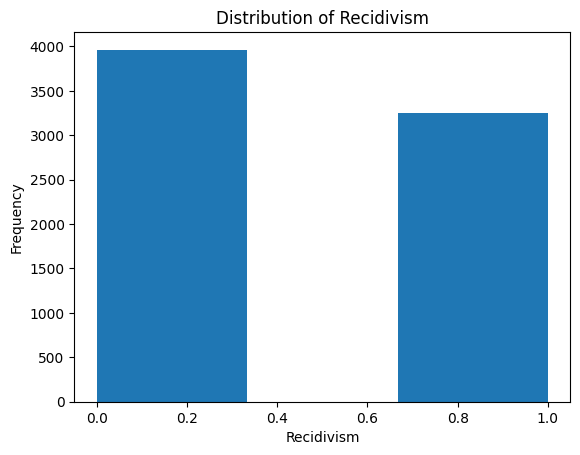

In [9]:
plt.hist(crimes['two_year_recid'].values, bins=3)
plt.title('Distribution of Recidivism')
plt.xlabel('Recidivism')
plt.ylabel('Frequency')
plt.show()

I thought it could insightful to explore patterns and correlation between recidivism rates and some demographic categories..

For example, I compare recidivism rate between different races, and it shows that African-American have higher recidivism rate. I think it's important to understand these differences as an algorithm that predicts a future criminal al offender may be biased from this statistics.

Also, there is quite a contrast in the recidivism rate between those who had committed a felony ant hose who committed a misdemeanour. As. matter of fact, a felony is a more serious criminal charge and those who have committed this kind of offence before show more probability of recidivism.

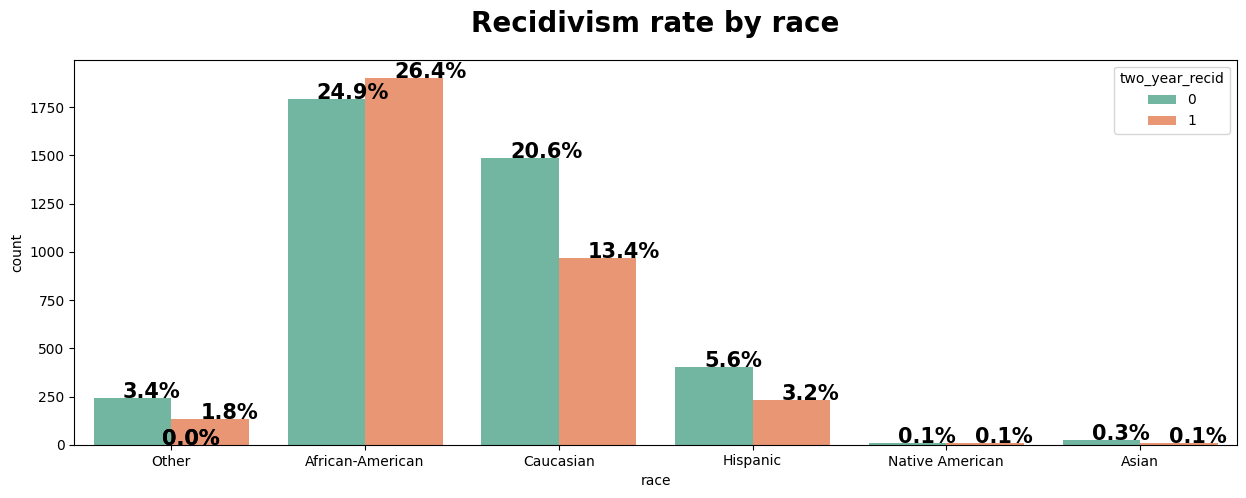

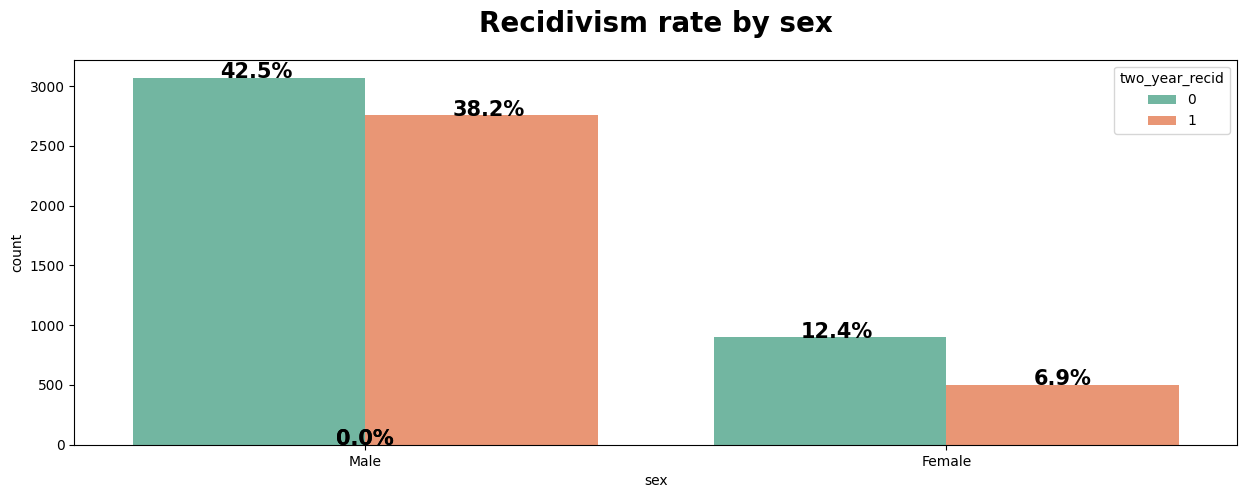

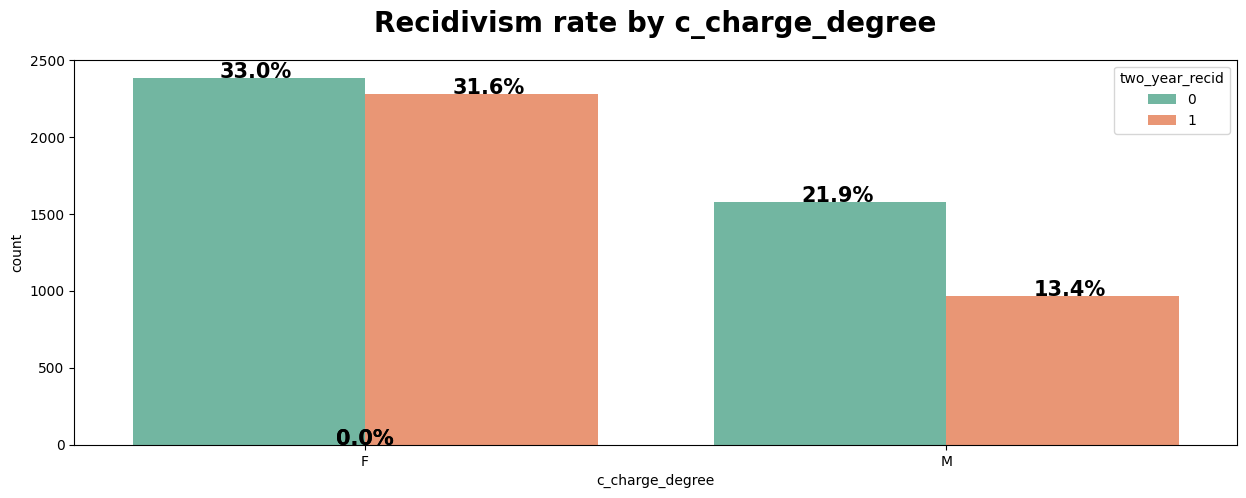

In [10]:
def countplot(column):
    plt.figure(figsize=(15,5))
    ax = sns.countplot(x=column, data=crimes, hue="two_year_recid",palette="Set2")
    for value in ax.patches:
        percentage = "{:.1f}%".format(100*value.get_height()/len(crimes[column]))
        x = value.get_x() + value.get_width() / 2 - 0.05
        y = value.get_y() + value.get_height()
        ax.annotate(percentage, (x,y), fontweight="black",size=15)
        
    plt.title(f"Recidivism rate by {column}",fontweight="black",size=20,pad=20)
    plt.show()

countplot("race")
countplot("sex")
countplot("c_charge_degree")

## Data Visualisation

In [11]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   two_year_recid       7214 non-null   int64 
 1   priors_count         7214 non-null   int64 
 2   age                  7214 non-null   int64 
 3   sex                  7214 non-null   object
 4   race                 7214 non-null   object
 5   c_charge_degree      7214 non-null   object
 6   has_juvenile_record  7214 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 394.6+ KB


In [12]:
print(crimes.dtypes)

two_year_recid          int64
priors_count            int64
age                     int64
sex                    object
race                   object
c_charge_degree        object
has_juvenile_record     int64
dtype: object


In [13]:
numerical_columns = crimes.select_dtypes(include=["float64", "int64"]).columns.tolist()

crimes[numerical_columns].describe()

,two_year_recid,priors_count,age,has_juvenile_record
count,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.450652,3.472415,34.817993,0.134877
std,0.497593,4.882538,11.888922,0.341615
min,0.000000,0.000000,18.000000,0.000000
25%,0.000000,0.000000,25.000000,0.000000
50%,0.000000,2.000000,31.000000,0.000000
75%,1.000000,5.000000,42.000000,0.000000
max,1.000000,38.000000,96.000000,1.000000


### Correlation Matrix

I decided to use a correlation matrix that evaluates how much each individual feature impacts the outcome. It is important to remember that this tool does not provide me a complete understanding of how each feature interacts with one another or their relationship affects the target feature. This only represents the linear relation between features and the expected outcome.

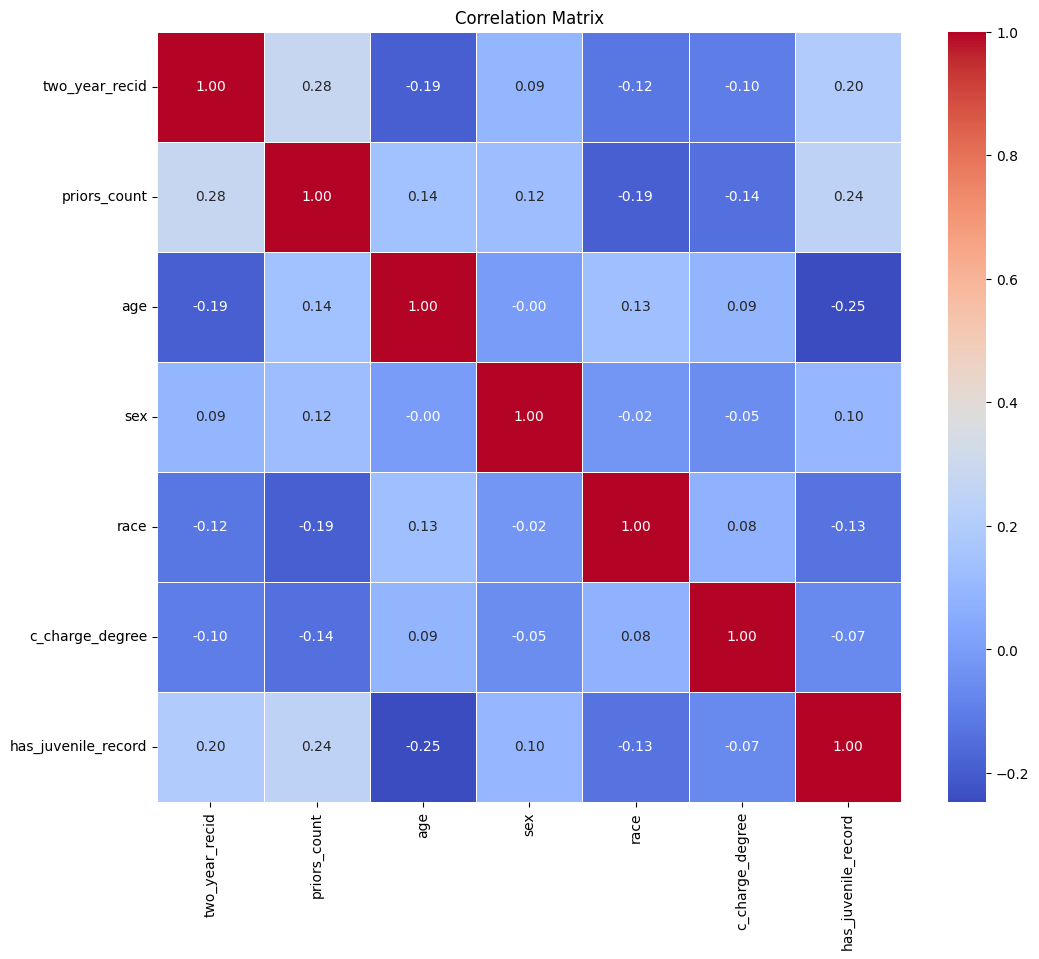

In [14]:
crimes_corr = crimes.copy()

categorical_columns = crimes_corr.select_dtypes(include=["object"]).columns.tolist()

label_encoder = LabelEncoder()

for col in categorical_columns:
    crimes_corr[col] = label_encoder.fit_transform(crimes_corr[col])

corr_matrix = crimes_corr.corr()

plt.figure(figsize=(12, 10))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

plt.title("Correlation Matrix")
plt.show()

In [15]:
target_corr = corr_matrix["two_year_recid"].sort_values(ascending=False)
print(target_corr)

two_year_recid         1.000000
priors_count           0.275117
has_juvenile_record    0.195347
sex                    0.092169
c_charge_degree       -0.104488
race                  -0.123109
age                   -0.190323
Name: two_year_recid, dtype: float64


The correlation analysis reveals that the strongest predictor of reoffending within two years is the number of prior offenses (priors_count), which aligns with expectations and is generally considered a justifiable feature. Juvenile records have an important relation to the target, but this kind of feature may reflect systemic disadvantages or family background rather than true risk, potentially causing misleading correlation. 

Notably, race has a weak negative correlation with recidivism, but this does not rule out indirect bias, as it may still be correlated with other highly weighted variables. 

# Handling Missing Values

In [16]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   two_year_recid       7214 non-null   int64 
 1   priors_count         7214 non-null   int64 
 2   age                  7214 non-null   int64 
 3   sex                  7214 non-null   object
 4   race                 7214 non-null   object
 5   c_charge_degree      7214 non-null   object
 6   has_juvenile_record  7214 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 394.6+ KB


In [17]:
crimes.isnull()

,two_year_recid,priors_count,age,sex,race,c_charge_degree,has_juvenile_record
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
7209,False,False,False,False,False,False,False
7210,False,False,False,False,False,False,False
7211,False,False,False,False,False,False,False
7212,False,False,False,False,False,False,False


In [18]:
crimes.isnull().sum(axis=0)

two_year_recid         0
priors_count           0
age                    0
sex                    0
race                   0
c_charge_degree        0
has_juvenile_record    0
dtype: int64

My starting dataset is completely clean, hence I decided to intentionally add missing values using the function add_missing. This way we can see if the model can handle a more realistic dataset that contains missing values by improving its robustness. Therefore, I made sure to add them using the following specific helper function:

In [19]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace=False)
    X.iloc[indexes] = np.nan
    return X

Let's apply specific percentages of missing values to some of the features: 

In [20]:
crimes["priors_count"] = add_missing(crimes["priors_count"], 0.12)
crimes["sex"] = add_missing(crimes["sex"], 0.10)
crimes["c_charge_degree"] = add_missing(crimes["c_charge_degree"], 0.11)
crimes["has_juvenile_record"] = add_missing(crimes["has_juvenile_record"], 0.09)


Now I check if the missing values have been correctly added:

In [21]:
crimes.isnull().sum(axis=0)

two_year_recid           0
priors_count           865
age                      0
sex                    721
race                     0
c_charge_degree        793
has_juvenile_record    649
dtype: int64

In [22]:
crimes

,two_year_recid,priors_count,age,sex,race,c_charge_degree,has_juvenile_record
0,0,0.0,69,Male,Other,NaN,0.0
1,1,0.0,34,Male,African-American,F,0.0
2,1,NaN,24,Male,African-American,NaN,1.0
3,0,1.0,23,Male,African-American,F,1.0
4,0,2.0,43,Male,Other,F,0.0
...,...,...,...,...,...,...,...
7209,0,NaN,23,Male,African-American,F,0.0
7210,0,0.0,23,Male,African-American,F,0.0
7211,0,0.0,57,Male,Other,F,0.0
7212,0,3.0,33,NaN,African-American,M,0.0


In [23]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   two_year_recid       7214 non-null   int64  
 1   priors_count         6349 non-null   float64
 2   age                  7214 non-null   int64  
 3   sex                  6493 non-null   object 
 4   race                 7214 non-null   object 
 5   c_charge_degree      6421 non-null   object 
 6   has_juvenile_record  6565 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 394.6+ KB


To better visualise the missing values, we use the missingno Python library.

In [24]:
!pip install missingno==0.5.2


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


<AxesSubplot: >

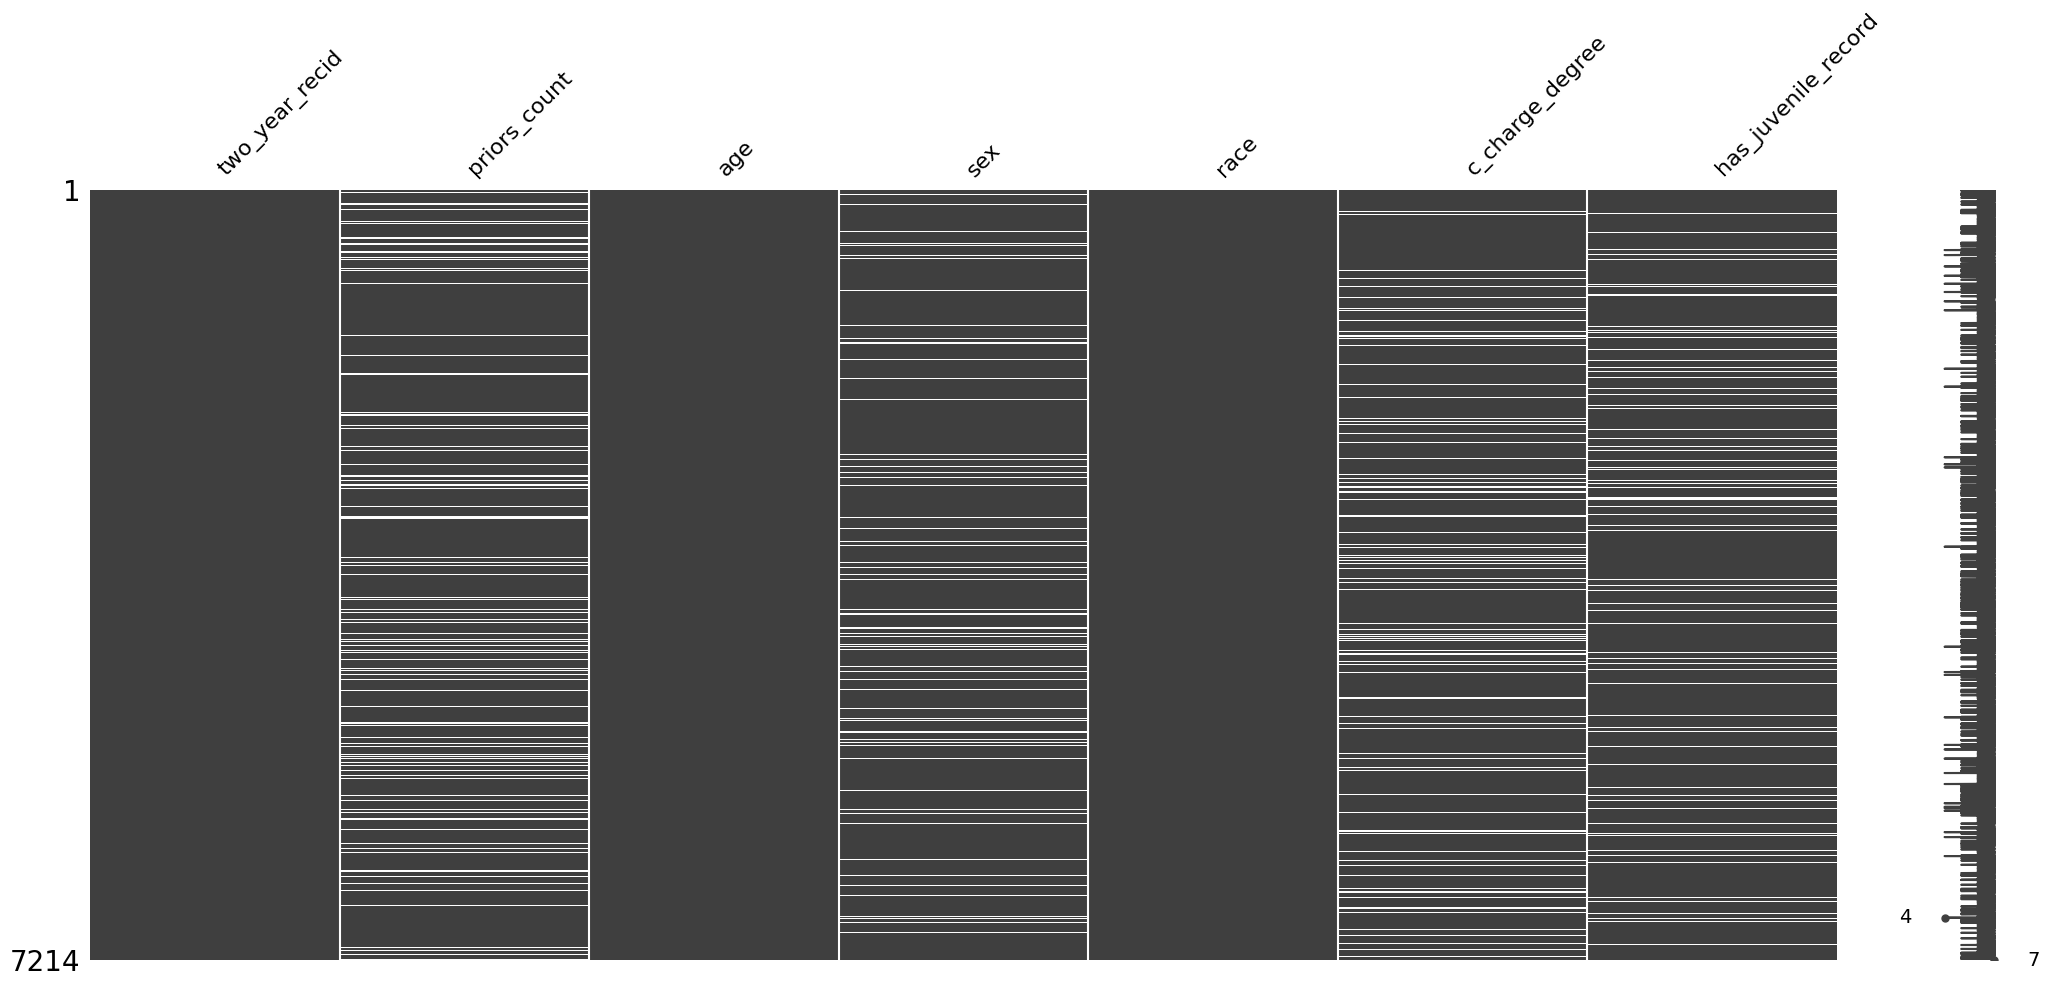

In [25]:
import missingno as msno
X = crimes
msno.matrix(X) 

Removing the columns or rows with the missing value is not a good solution because we would almost remove most of the dataset, so we have to take in consideration the imputation technique.

We see the dataset after the initial preprocessing of the dataset:

In [26]:
crimes

,two_year_recid,priors_count,age,sex,race,c_charge_degree,has_juvenile_record
0,0,0.0,69,Male,Other,NaN,0.0
1,1,0.0,34,Male,African-American,F,0.0
2,1,NaN,24,Male,African-American,NaN,1.0
3,0,1.0,23,Male,African-American,F,1.0
4,0,2.0,43,Male,Other,F,0.0
...,...,...,...,...,...,...,...
7209,0,NaN,23,Male,African-American,F,0.0
7210,0,0.0,23,Male,African-American,F,0.0
7211,0,0.0,57,Male,Other,F,0.0
7212,0,3.0,33,NaN,African-American,M,0.0


In [27]:
(crimes == 0).sum()    #number of zeros showing in the dataset

two_year_recid         3963
priors_count           1887
age                       0
sex                       0
race                      0
c_charge_degree           0
has_juvenile_record    5677
dtype: int64

# Preprocessing

## Pipeline

Let's divide the dataset in a training set X, which includes all the columns except the target feature, and a test set y, which only includes the target feature.

In [28]:
X = crimes.drop(columns=["two_year_recid"])
y = crimes["two_year_recid"]

Before defining a pipeline, I group my features into categories: 

1. Numerical (all discrete) features

- priors_count

- has_juvenile_record

- age

2. Categorical (all nominal) features

- c_charge_degree

- sex

- race

<img src="Copia di Testo del paragrafo.png" width="" align="" />

Note: we treat the degree of the charge as a nominal feature because it simplifies the work of prediction, having only two categories, "felony" or "misdemeanour", the order does not influence the final prediction, treating it as an ordinal would imply a numerical relation that could bias the model.

This preprocessing pipeline is structured to handle both numerical and categorical features efficiently while ensuring data quality and consistency before feeding the data into a machine learning model. 

For missing values, numerical features are imputed using the median, which gives more stable values and represents the central tendency value of the feature and helps avoiding bias, while categorical features are filled using mode imputation to retain the most frequent category and avoid data distortion. 

In [29]:
# discrete numerical features
numeric_missing = ['priors_count', 'has_juvenile_record']
numeric = ['age']

# Categorical nominal features 
categorical_missing = ['c_charge_degree'] 
categorical = ['sex', 'race']


Numerical variables are then standardized using a Standard Scaler, ensuring they have a mean of zero and a unit variance, which is particularly useful for models sensitive to feature magnitudes. Whereas One-Hot Encoding is used for categorical nominal variables to prevent the model from inferring a false ordinal relationship. This structured approach ensures that the data is well-prepared for training, reducing noise while maintaining interpretability and efficiency.

In [30]:
numeric_transformer_missing = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer_missingg = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop=None, handle_unknown="ignore"))
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(drop=None, handle_unknown="ignore"))
])

With handle_unknown='ignore', OneHotEncoder just leaves all zeros when it sees a category it didn’t encounter during training. This way, the model can still run without errors. And I use drop=None so an unseen category is assigned all-zeros but any seen category has a 1 somewhere. I decide to do this because having had drop="first" and handle_unknown="ignore" would make unknown categories indistinguishable from the dropped category.

## Column Transformer

To make sure that both numerical and categorical features are processed correctly, I now put the defined pipelines within a single structure.

In [31]:
final_transformation = ColumnTransformer(
    transformers=[
        ("num_missing", numeric_transformer_missing, numeric_missing),
        ("num_clean", numeric_transformer, numeric),
        ("cat_missing", categorical_transformer_missingg, categorical_missing),
        ("cat_clean", categorical_transformer, categorical)
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0
)

remainder='drop'	Drops columns that aren’t explicitly transformed.
verbose_feature_names_out=False	Removes transformer name prefixes for cleaner feature names.
sparse_threshold=0	Forces output to be a dense NumPy array.

We apply the preprocessor to the dataframe to check if it works:

In [32]:
crimes_copy = crimes.copy()

try:
    processed_data = final_transformation.fit_transform(crimes_copy)

    feature_names = final_transformation.get_feature_names_out()
    processed_crimes = pd.DataFrame(processed_data, columns=feature_names)

    print(" Preprocessing completed successfully!")
    print("Shape of processed data:", processed_crimes.shape)

except Exception as e:
    print(" Error during preprocessing:", e)


 Preprocessing completed successfully!
Shape of processed data: (7214, 14)


# Training and Test sets

Now, I can split the entire dataset into training and test sets, putting 20% of the instances in the test set (note that I'll be using the test set only at the end of the model selection process).

In [33]:
# Division of the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,random_state=30, shuffle=True
)

X_train, X_test → Contain the training and test features, respectively.
y_train, y_test → Contain the training and test labels.
test_size=0.2 → Allocates 20% of the data to the test set and 80% to the training set.
stratify=y → Ensures that the class distribution remains the same in both sets, preventing imbalance.
random_state=30 → Ensures reproducibility of the split.
shuffle=True → Randomly shuffles the data before splitting to ensure a fair distribution.

In [34]:
print(X_train.columns)

Index(['priors_count', 'age', 'sex', 'race', 'c_charge_degree',
       'has_juvenile_record'],
      dtype='object')


# Model Selection

Model selection involves choosing the model that performs best on a dataset by comparing different options based on how well they make predictions. The goal is to choose a model that works well not only on the training data but also on new, unseen data, avoiding both underfitting and overfitting. In this case, model selection is carried out through nested cross-validation, which brings together hyperparameter tuning and performance evaluation in one clear process.

I built a complete pipeline: I selected RandomOverSampler as default sampling method to balance classes, PCA as default dimensionality reduction method with n_components=6, in order to not lose dimensions-as they are very few already- but also not skipping this step. At last, I chose Perceptron as default classifier as it is not computationally expensive and works well for binary classification.

In [35]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', RandomOverSampler(random_state=42)),
    ('dim_reduction', PCA(n_components=6)),  
    ('classifier', Perceptron())
])


In [36]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num_missing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['priors_count',
                                                   'has_juvenile_record']),
                                                 ('num_clean',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('cat_missing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['c_charge_degree']),
                                                 ('cat_clean',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'race'])],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomOverSampler(random_state=42)),
                ('dim_reduction', PCA(n_components=6)),
                ('classifier', Perceptron())])

The following code generates predictions for X_test using the trained model in model_pipeline.

In [37]:
model_pipeline.predict(X_test)

array([0, 1, 1, ..., 0, 1, 0])

## Configuration 

sampler_configs  sets how we want to handle imbalanced classes in our data. Some options are: don’t change anything; use RandomOverSampler or SMOTE. These methods help the model treat both classes equally, so it does not become biased toward the majority class.

None: this means no resampling. You keep the class imbalance as it is — the model learns from the original, imbalanced data.

RandomOverSampler: this one duplicates random samples from the minority class to balance the data. It doesn’t create new data like SMOTE, but just makes copies to match the size of the majority class.

I only test None and RandomOverSampler, without SMOTE, because classes inside the target feature are already fairly balanced and I wouldn't want to unnecessarily apply sampling methods that could take long to run in the cross-validation step.

I assign RandomOverSampler the sampling strategy [1.0] because I don't want to interferer with classes too much because as I already mentioned, they are already quite balanced, so [1.0] represents minority=majority, treating classes equally. Performance of the model 

In [38]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler': [RandomOverSampler()], 
        'sampler__sampling_strategy': [1.0],
    }
]

dim_configs helps reduce the number of features in your dataset so the model can learn faster and avoid overfitting (memorizing too much noise).

None: dimensionality reduction is skipped and all dimensions remain unchanged.

PCA: Keeps the most important information (variance) while dropping less useful features.                                                                                       

I gave PCA the parameter of n_components = 6, the same number of my features, because I have very few dimensions already, and I was concerned that by possibly reducing them even more, my model could not generalise well and learn patterns from such few information.

In [39]:
dim_reduction_configs = [
    {
        'dim_reduction': [None]  
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [6]
    }
]

classifier_configs  --> specifies various classification models and their hyperparameter settings, in my case I chose to test LogisticRegression, Random Forest, SVC and Gradient Boosting. They are the most classical classifiers and they work well on binary classification. This configuration allows for systematic testing of different models to identify the most effective one for the given dataset.

In [40]:
classifier_configs = [
    {
        'classifier': [LogisticRegression(solver='liblinear', max_iter = 500)],
        'classifier__C' : [0.1, 0.5, 1, 2, 5],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': [None]
    },
    {
        'classifier': [SVC(kernel='rbf', random_state=42)],
        'classifier__C': [0.5, 1, 2, 5],
        'classifier__gamma': ["scale", 0.1, 0.01]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [200, 300, 500],
        'classifier__max_depth': [None, 6, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    {    
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__learning_rate': [0.03, 0.05, 0.1],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [2, 3]
    },
]

### Combine all configurations

We now generate all combinations by combining sampling techniques, dimensionality reduction methods, and classifiers into a structured list of dictionaries. Each combination will be tested via nested cross-validation.

In [41]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [42]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 16'

I obtained 16 configurations as results of the Cartesian product of Sampler, Dimensionality and Classifier configurations: 2×2×4=16

I checked that the configuration of the possible model are correctly implemented

In [43]:
all_configs[:3]

[{'sampler': [None],
  'dim_reduction': [None],
  'classifier': [LogisticRegression(max_iter=500, solver='liblinear')],
  'classifier__C': [0.1, 0.5, 1, 2, 5],
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None]},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [SVC(random_state=42)],
  'classifier__C': [0.5, 1, 2, 5],
  'classifier__gamma': ['scale', 0.1, 0.01]},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [RandomForestClassifier()],
  'classifier__n_estimators': [200, 300, 500],
  'classifier__max_depth': [None, 6, 10],
  'classifier__min_samples_leaf': [1, 2, 4]}]

## Cross Validation

Cross-validation is a way to check how well a model works by splitting the data into several training and testing parts. By switching which part is used for testing in each round, it gives a more reliable measure of performance and helps make sure the model isn’t just fitting one specific split, by overfitting or underfitting.

In [44]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

I used the method StratifiedKFold() in order to guarantee that classes distribution in each fold is proportional to the one of the entire vector.

In [45]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs)*5,
    n_jobs=-1,
    cv = inner_cv,
    scoring='f1'
)

In [46]:

scores = cross_validate(
    rs,
    X_train,
    y_train,
    scoring="f1",
    cv=outer_cv,
    return_estimator=True,
    verbose=3,
    error_score="raise",
)

[CV] END ......................................., score=0.609 total time= 1.2min
[CV] END ......................................., score=0.630 total time= 1.1min
[CV] END ......................................., score=0.624 total time= 1.0min
[CV] END ......................................., score=0.648 total time= 1.1min
[CV] END ......................................., score=0.652 total time=  59.6s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min finished


These F1-scores are the cross-validation's scores obtained for different model evaluations. Each iteration corresponds to a fold in the cross-validation process, where the model is trained and tested on different subsets of the data.  The F1-scores vary between 0.60 and 0.65 indicating minimal fluctuation in model performance across different validation sets, which suggests that the model generalizes well.

In [47]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

RandomOverSampler(sampling_strategy=1.0)
None
GradientBoostingClassifier(learning_rate=0.05, max_depth=2, n_estimators=200,
                           random_state=42) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.6087786259541985
----------
RandomOverSampler(sampling_strategy=1.0)
None
GradientBoostingClassifier(learning_rate=0.03, max_depth=2, random_state=42) {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.03, 'loss': 'log_loss', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split'

The classifier that seems to be working better is GradientBoosting, therefore it will be the selected model.

In [48]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_test, average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.6737589028143701, F1 on test set:0.6677879344999998
F1 on training set:0.6682395693870581, F1 on test set:0.6673759053447808
F1 on training set:0.6632441186702479, F1 on test set:0.6618258452270677
F1 on training set:0.6688162143652343, F1 on test set:0.663272246658181
F1 on training set:0.669709302668092, F1 on test set:0.665274337447955


The F1-scores on the training and test sets are nearly identical, showing that the model generalizes well and is not overfitting. With only minimal variation across runs, the results indicate the model maintains a consistent balance between learning from the training data and performing on unseen data.

# Refinement of the model

After nested cross-validation has pointed out the best-performing pipeline configuration, the refinement of the selected model involves optimizing the chosen model by performing hyperparameter tuning, using RepeatedStratifiedKFold and RandomizedSearch to find and stabilise the best parameters for the chosen classifier.

This step ensures that the model is fine-tuned for maximum efficiency before final evaluation and deployment.

In [49]:
cv_strategy = RepeatedStratifiedKFold(
    n_splits=5, 
    n_repeats=2, 
    random_state=42
)

In [50]:
best_model_pipeline=IMBPipeline([
    ("trans", final_transformation),
    ("sampler", RandomOverSampler(sampling_strategy=1.0)),
    ("classifier", GradientBoostingClassifier())
])

In [51]:
params = {
    'classifier__learning_rate': [0.03, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [2, 3]
}

In [52]:
rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,    
    param_distributions=params,      
    cv=cv_strategy,                   
    n_iter=10,                         
    scoring="f1",                     
    n_jobs=-1,                        
    random_state=42
)

In [53]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('num_missing',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['priors_count',
                                                                                'has_juvenile_record']),
                                                                              ('num_clean',
                                                                               Pipeline(steps=[('s...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['sex',
                                                                                'race'])],
                                                                verbose_feature_names_out=False)),
                                             ('sampler',
                                              RandomOverSampler(sampling_strategy=1.0)),
                                             ('classifier',
                                              GradientBoostingClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.03,
                                                                      0.05,
                                                                      0.1],
                                        'classifier__max_depth': [2, 3],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=42, scoring='f1')

In [54]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num_missing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['priors_count',
                                                   'has_juvenile_record']),
                                                 ('num_clean',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('cat_missing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(stra...most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['c_charge_degree']),
                                                 ('cat_clean',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'race'])],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomOverSampler(sampling_strategy=1.0)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2))])

In [55]:
print("Best params (refined):", rs_best.best_params_)
print("Mean CV F1 (refined):", rs_best.best_score_)

Best params (refined): {'classifier__n_estimators': 100, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.03}
Mean CV F1 (refined): 0.637395214627431


In [56]:
cls = rs_best.best_estimator_

# Model Evaluation Metrics

## Learning Curve

The learning curve provides insights into the model's performance as the training dataset size increases. It typically shows two curves: one for the training score and one for the validation score.

In [57]:

train_sizes, train_scores, test_scores = learning_curve(
    estimator=rs_best.best_estimator_,
    X=X_train,
    y=y_train,
    train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=cv_strategy,        
    n_jobs=-1,
    scoring='f1',
    shuffle=True,
    random_state=42
)

(0.6, 1.03)

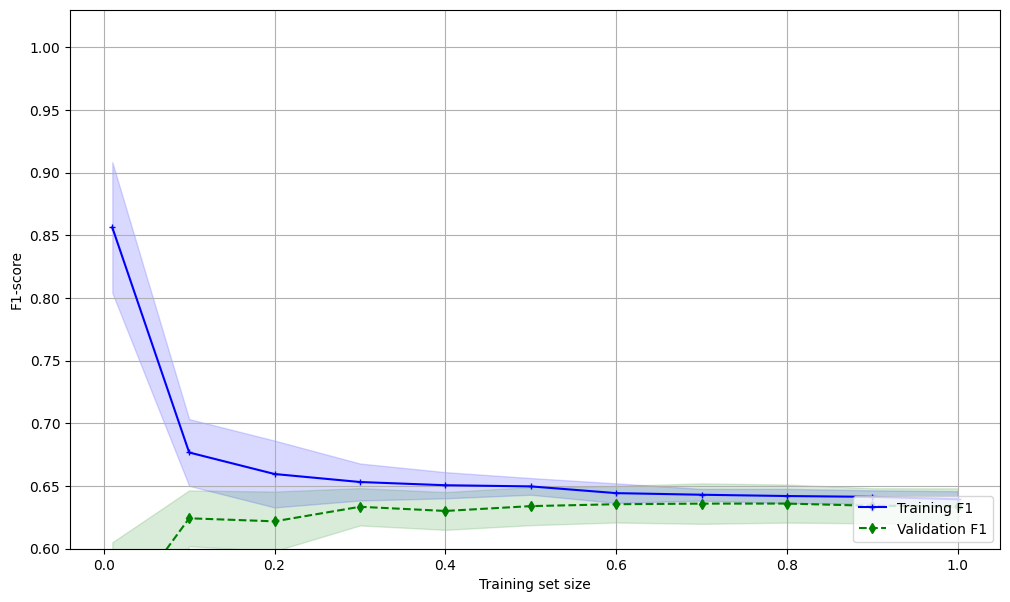

In [58]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

train_sizes = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
        color='blue', marker='+',
        markersize=5, label='Training F1')

ax.fill_between(train_sizes,
                train_mean - train_std,
                train_mean + train_std,
                alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='d', markersize=5,
        label='Validation F1')

ax.fill_between(train_sizes,
                test_mean - test_std,
                test_mean + test_std,
                alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])  

The learning curve shows that when the training set is still small the F1 score is very high, showing possible overfitting, then it quickly drops as the set grows bigger and remains steady around 0.64-0.65. The validation rate grows steadily and stabilises around 0.64-0.65.                               The model generalises well, without memorising the training data, as we can see from the F1 and validation scores that almost coincide as the set grows. But it is clear that the scores are quite low, around 0.64-0.65, therefore we deduce that the model does not perform particularly well on the given data, which could be due to the features not showing enough complexity and not having strong correlations.

## Confusion Matrix

A confusion matrix is a way to evaluate classification models by comparing actual vs. predicted labels. It breaks predictions into four categories:

True Positives (TP) → Correctly predicted positive cases. 
True Negatives (TN) → Correctly predicted negative cases
False Positives (FP) → Incorrectly predicted as positive (Type I Error)
False Negatives (FN) → Incorrectly predicted as negative (Type II Error)

Confusion Matrix: 
[[539 254]
 [229 421]]


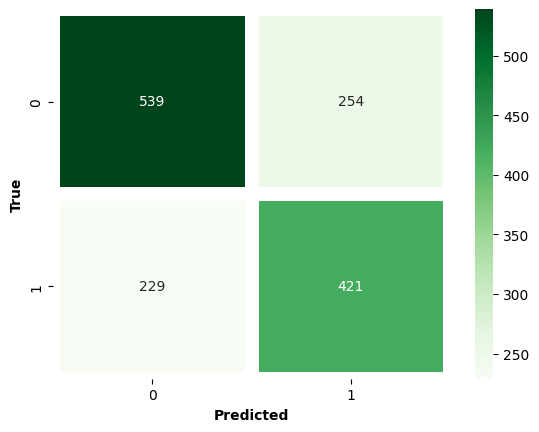

In [59]:
cls = rs_best.best_estimator_

y_pred = cls.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"Confusion Matrix: \n[[{tn} {fp}]\n [{fn} {tp}]]")

sns.heatmap([[tn, fp], [fn, tp]], linewidths=10, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.show()

True Positives (TP) → 421 
True Negatives (TN) → 539
False Positives (FP) → 254
False Negatives (FN) → 229

The model is able to predict well the true cases, but there are still inaccuracies as seen from the false positives and false negatives rates.

## Roc Curve

The ROC Curve (Receiver Operating Characteristic Curve) visualizes the model's ability to distinguish between classes by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds.

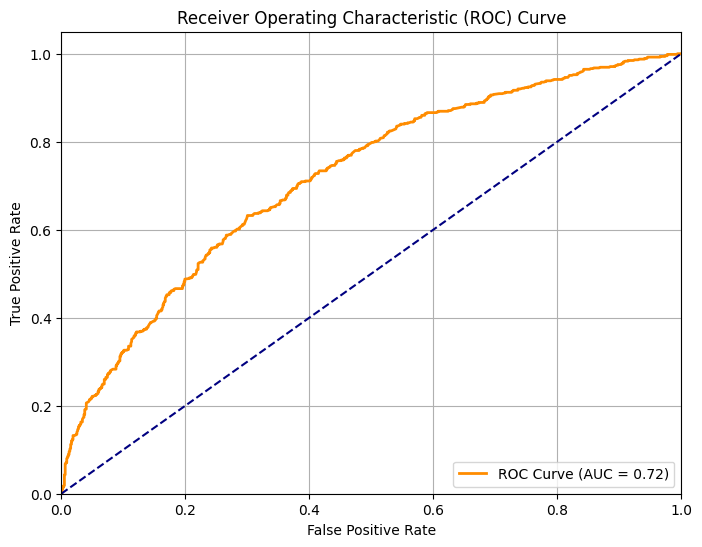

In [60]:
best_model_pipeline.fit(X_train, y_train)

y_prob = best_model_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The ROC curve shows good and effective ability to distinguish between classes, and with the AUC=0.72 the refined model performs better than random guessing. It aligns with the cross-validation F1-scores and the learning curve insights, showing good ability to generalise on unseen data.

# Conclusion

The final model, Gradient Boosting, achieves moderate predictive performance. Cross-validation stabilizes around an F1-score of ~0.65, correctly classifying many cases but still producing a fair share of false positives and false negatives. The ROC curve (AUC = 0.72) confirms that the model has reasonable discriminative power. Importantly, the learning curve suggests the model is not overfitting, but its performance is probably undermined by the quality of the features and is not able to recognise strong patterns.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=17a4d1ac-8bb8-45be-b58c-a266d2572e60' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>